#                                   IMA205 Challenge 2022 Report
##                     Classify dermoscopic images among 8 different diagnostic classes. 
###                         Realized by: BAAMARA Slimane

#### Introduction

A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become cancer, with melanoma being the deadliest skin cancer. Its incidence has increased during the last decades, especially in the areas mostly populated by white people.

#### Data Preprocessing and Segmentation and Postprocessing

In order to have some features for the classification of different images into one of the 8 classes. In to do that, we should extract features such as the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (usually called the ABCD rule). And those features are mainly extracted from the image region delimited by the mask. As we don't have all image masks, I have first worked on image segmentation, in order to obtain an image mask that is as accurate as possible, as the features that will be extracted will be based on it.

To do so, I first used some classic approches, like watershed, graph-cuts. But the results weren't very good.
In Section 1, I illustrate some results obtained using graph-cuts, where I first choose three regions (cleared and dark skin regions + a background region), as this method is based on Gaussian_mixture, which means that it separates the forground from background based on the Gaussians that characterises each region. It does two times the segmentation, where in the first time it does graph cut using the distance of the mean of each image channel to the mean of the object/background patches. Then, based on this  first segmentation, it extractes 5 clusters from the object and the background basing n the obtained mask, then calculate the neg_log_likelihood for both object and background, and use it to compute graph-cuts, in order to have more precise segmentation.

I chosed to use dark and clear regions, as I noticed that in most of the cases we had this characterestic. I also, added a short processing to overcome the problem of having some objects that have same color as the skin but are not skin (bandage, ..), by constraining the object to be near to the center of the image.

This method works perfectly in most of the cases, but misses object that have background of the same color as the object as well as the objects that are not located in the center.

Then, I though of incorporating Deep Neural Networks, like UNET, that have shown good results in image segmentation.

Based on some videos from Youtube, and the original paper of UNET, I succeded to implement UNET, and to train it on the images that have masks, then used it to predict masks for the images that do not have mask, as well as, for the test images.

The results of segmentation are not shown in this notebook, as it took two days, in order to complete 100 epochs of training.
And the results obtained, where: 92% accuracy and 0.8 Dice score.

In order to improve the results, I used two approaches. In the first one I used the same Idea as before, by considering the mask obtained by UNET as the first step of Graph-cuts, then, by filtering out small objects then, by applying an erosion of size 5, I get the object region, and by applying a delatation of 70 - dilatation of 50, I obtain the background region, then I apply kmeans to obtain the clusters from each region then I apply graph-cuts. This approach didn't improve too much the results.

The second approach, was to filter out small objects, then to apply a simple dilatation of size 20. and this imroved the dice score by 0.1, to be 0.9.

In order to train UNET, the section 2, explain what should be set as parameter to do so.

In order to do the postprocessing after UNET, the section 3, explain what should be set as parameter to do so.

#### Feature extraction

Based on some articles from the Literature. I tried to extract Geometric and Coloremetric features. The code base for this section is in the file feature_extraction.py

The function: Geometric_features, allows the extraction of some geometrical features using regionprops on the mask. features like: perimeter, area, compactness, formfactor and too many other features that characterises the segmented image/mask.

The function: extract_feature, allows the extraction of features like: horizental/vertical asymetries, max_axe and min_axe

The function: colorometric_features, allows the extraction of features like: number of colors present in the lesion, Asymetry of the Black, Blue Gray, Dark Brown, Light Brown, White colors.

#### Classification

After the extraction of the feature, we perform a the classification using Non_linear SVM and Random_forest.

In the section 5, we first perform feature selection using PCA, and we observe that only 38 features out of 260, can explain 99% of the data variability, thus we use only the 38 selcted components. Then we perform classification using Gread Search to fetch for the best hyperparameters, then we plot the confusion Matrix to evaluate the results.

Finally, using the best parameters, we predict the Classes for the test dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import  cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from sklearn.cluster import KMeans
from skimage import morphology
from scipy.spatial.distance import dice

import glob
from mpl_toolkits.axes_grid1 import AxesGrid

#### Section 1: Image Segmentation using Graph-cuts

In [ ]:
from skimage.io import imread
import glob
Working_directory="./Train/Train"

mask_files = [f for f in sorted(glob.glob(Working_directory+'/*.png'))]
image_files = [f for f in sorted(glob.glob(Working_directory+'/*.jpg')) if '.'+f.split('.')[1]+'_seg.png' in mask_files]

im = imread(image_files[8])
dark_obj = im[150:250, 150:300]
im = imread(image_files[6])
clear_obj = im[150:250, 150:300]
bg = im[50:150, 350:450]
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(dark_obj)
plt.subplot(1,3,2)
plt.imshow(clear_obj)
plt.subplot(1,3,3)
plt.imshow(bg)

In [ ]:
from graph_cuts import *

mean_object_dark = np.array([np.mean(dark_obj[:, :,0]), np.mean(dark_obj[:, :,1]), np.mean(dark_obj[:, :,2])])
mean_object_clear = np.array([np.mean(clear_obj[:, :,0]), np.mean(clear_obj[:, :,1]), np.mean(clear_obj[:, :,2])])
mean_background = np.array([np.mean(bg[:, :,0]), np.mean(bg[:, :,1]), np.mean(bg[:, :,2])])
# Dir_1 = './Test/new_masks_1/'
# Dir_2 = './Test/new_masks_2/'
# Dir_3 = './Test/failed/'

fail_cases = []
for i in range(2):
    print('iter:', i,'/', len(image_files))
    filename = image_files[i]
    im = imread(filename)
    im_bin = segment_1(im , mean_object_dark, mean_object_clear, mean_background,p=1, beta = 100) 
    x, y = im_bin.shape
    cx, cy = int(x/2), int(y/2)
    if np.sum(im_bin[cx-100:cx+100, cy-100:cy+100]) < 350:
        im_bin = segment_1(im, mean_object_dark, mean_object_clear, mean_background,p=0, beta = 100)
        x, y = im_bin.shape
        cx, cy = int(x/2), int(y/2)
        if np.sum(im_bin[cx-100:cx+100, cy-100:cy+100]) < 350 or np.sum(im_bin) == x*y:
            fail_cases.append(filename)
            # imsave(Dir_3 + filename.split('/')[-1].split('.')[0] + '_seg.png', im_bin)            
        else:
            # imsave(Dir_1 + filename.split('/')[-1].split('.')[0] + '_seg.png', im_bin)
            neg_log_obj, neg_log_bg = clustering(im, im_bin)
            im_bin_ = segment_2(im, neg_log_bg, neg_log_obj)
            # imsave(Dir_2 + filename.split('/')[-1].split('.')[0] + '_seg.png', im_bin)
    else:
        # imsave(Dir_1 + filename.split('/')[-1].split('.')[0] + '_seg.png', im_bin)
        neg_log_obj, neg_log_bg = clustering(im, im_bin)
        im_bin_ = segment_2(im, neg_log_bg, neg_log_obj)
        # imsave(Dir_2 + filename.split('/')[-1].split('.')[0] + '_seg.png', im_bin)
    fig = plt.figure(figsize=(12, 12))
    grid = AxesGrid(fig, 111,
                    nrows_ncols = (1, 2),
                    axes_pad = 0.5)
    grid[0].imshow(im)
    grid[0].axis('off')
    grid[0].set_title("image")
    grid[1].imshow(im_bin,cmap='gray')
    grid[1].axis('off')
    grid[1].set_title("segmentation mask")



#### Section 2: Image Segmentation using UNET

In order to reproduce the training of UNET the following parameters should be taken into consideration: 

1.  Set images directory in train.py file. Based on the mask_files, image_files from section 1, I have the list of the images with mask, I did a randm split of the images into training and validation and test sets, then I seved the coresponding images to the following directories: 
    - TRAIN_IMG_DIR = "data/train_images/"
    - TRAIN_MASK_DIR = "data/train_masks/"
    - VAL_IMG_DIR = "data/val_images/"
    - VAL_MASK_DIR = "data/val_masks/"
    - SAVE_IMG = "data/saved_images/" ==> path to where the resulting masks should be saved

2. I order to train UNET from scratch, the parameter LOAD_MODEL in train.py, should be set to False. Otherwise, in order to load a pretrained weights,  LOAD_MODEL = True, and the path to CHECKPOINT_PATH, should be set.

3. After finishing with the parameters, the following cell, should be executed to launch the training

In [ ]:
!python train.py

In order to use UNET to do only predictions on Test datasets, we execute the following cell by setting first the following parameters:

- LOAD_MODEL = True
- TEST_IMG_DIR = "data/test_images/" ==> path to the directory containing the test images
- TEST_MASK_DIR = "data/test_masks/" ==> path to the directory containing the test masks (Ground truths)
- UNET_MASKS_DIR = "data/predicted_Unet/" ==> path to the directory to which the predicted masks will be saved
- CHECKPOINT_PATH = "checkpoint/my_checkpoint.pth.tar" ==> path to the directory containing the trained weights

In [ ]:
!python predict.py

#### Section 3: Postprocessing after UNET

The postprocessing.py file does many tasks, and in order to use it as a postprocessing after UNET, the following parameters should be set:
For OPT, as explained above, we have two methods, and by setting OPT, we use one of them:

- OPT = 0 # 0: filter small obj and make a dilatation of the predicted masks by Unet. 1: filter small obj, erosion & dilatations to produce forground/background regions for graph cut

- PREDICTION = False, as we are not using this postprocessing to predict masks but to evaluate UNET results using postprocessing
- TEST_IMG_DIR = "data/test_images/" ==> path to directory that contains test images that will be used to evaluate segmentation results 
- TEST_MASK_DIR = "data/test_masks/" ==> path to directory that contains test masks (Ground truths) that will be used to evaluate segmentation results. 
- FOLDER_SAVE_PREDICT="data/saved_predictions_train/" ==> path to directory to which the postprocessed masks are saved 
- FOLDER_SAVE_CROPED = "data/saved_crops_train/" ==> path to directory to which the croped rectangle image that delimites the postprocessed mask. (could be used to train a CNN based on only images to do image classification)


In [341]:
!python postprocessing.py

=> Loading checkpoint
save_prediction 0 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
save_prediction 1 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
save_prediction 2 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
save_prediction 3 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
save_prediction 4 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
save_prediction 5 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
save_prediction 6 / 292 as_imgs
Lossy conversion from int64 to uint8. Range [0, 1]. 

As we can see after postprocessing, the IOU increses from 0.8 to 0.9

In the following code, we will use postprocessing.py to predict masks for images in Train/Train folder that do not have a mask

In [ ]:
Working_directory="./Train/Train"

# We first extract the images that do not have mask
mask_files = [f for f in sorted(glob.glob(Working_directory+'/*.png'))]
image_files = [f for f in sorted(glob.glob(Working_directory+'/*.jpg')) if '.'+f.split('.')[1]+'_seg.png' not in mask_files]
# We save the list of images without mask to a text file
textfile = open("data/images_no_mask.txt", "w")
for element in image_files:
    textfile.write(element + "\n")
textfile.close()

After saving the list of images without masks, we execute the postprocessing function that computes the masks for this images.
The following parameters should be set on the file 'postprcessing.py':
- OPT = 0
- PREDICTION = True
- IMAGE_NO_MASK = "data/images_no_mask.txt" ==> text file from which we load the list of images without mask 
- FOLDER_SAVE_PREDICT="data/saved_predictions_train/" ==> path to directory to which the postprocessed masks are saved 
- FOLDER_SAVE_CROPED = "data/saved_crops_train/" ==> path to directory to which the croped rectangle image that delimites the postprocessed mask. (could be used to train a CNN based on only images to do image classification)

In [ ]:
!python postprocessing.py

Now we execute the postprocessing.py file on the Test data that will be used for submission in order to predict the masks, by setting the following parameters:

- FOLDER_SAVE_PREDICT="data/saved_predictions_test/" ==> path to the folder where the new masks will be saved
- FOLDER_SAVE_CROPED = "data/saved_crops_test/"  ==> path to which the cropped images will be saved
- IMAGE_NO_MASK = "data/test_images_no_mask.txt"  ==>  path to the list of image's path without mask
- OPT = 0 
- PREDICTION = True

In [ ]:
test_dataset = pd.read_csv('metadataTest.csv')
Working_directory="./Test/Test"

# We first extract the images that do not have mask
mask_files = [f for f in sorted(glob.glob(Working_directory+'/*.png'))]
image_files = [f for f in sorted(glob.glob(Working_directory+'/*.jpg')) if '.'+f.split('.')[1]+'_seg.png' not in mask_files]
textfile = open("data/test_images_no_mask.txt", "w")
for element in image_files:
    textfile.write(element + "\n")
textfile.close()

In [ ]:
!python postprocessing.py 

Finally, before going to feature extration part, we should merge all the training/testing masks in one folder

In [ ]:
import shutil
Working_directory = "./Train/Train"
current_folder = "data/saved_predictions_train/"
mask_files = [f for f in sorted(glob.glob(Working_directory+'/*.png'))]
for i in range(len(mask_files)):
    shutil.copy(mask_files[i], current_folder+mask_files[i].split('/')[-1])
mask_files = [f for f in sorted(glob.glob(current_folder+'/*.png'))]

In [ ]:
Working_directory = "./Test/Test"
current_folder = "data/saved_predictions_test/"
mask_files = [f for f in sorted(glob.glob(Working_directory+'/*.png'))]
for i in range(len(mask_files)):
    shutil.copy(mask_files[i], current_folder+mask_files[i].split('/')[-1])

#### Section 4: Feature selection

In [79]:
train_dataset = pd.read_csv('metadataTrain.csv')
test_dataset = pd.read_csv('metadataTest.csv')
test_dataset

,ID,SEX,AGE,POSITION
0,ISIC_0055289,female,50.0,lower extremity
1,ISIC_0062682,male,65.0,lower extremity
2,ISIC_0057706,female,75.0,NaN
3,ISIC_0031702,male,70.0,head/neck
4,ISIC_0069272,male,60.0,lower extremity
...,...,...,...,...
6328,ISIC_0028560,male,85.0,upper extremity
6329,ISIC_0068188,female,75.0,upper extremity
6330,ISIC_0072611,female,50.0,palms/soles
6331,ISIC_0032918,male,50.0,head/neck


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

class_names = ["Melanoma","Melanocytic nevus", "Basal cell carcinoma", "Actinic keratosis", "Benign keratosis", "Dermatofibroma", "Vascular lesion", "Squamous cell carcinoma"]

# This fuctions allows to extract the X and y given dataframe obteined from metadataTrain.csv and the extracted features
def extract_x_y(data1, data2, training, list_cols):
    if training:
        df = data1[['ID', 'CLASS', 'SEX', 'AGE']]
    else:  
        df = data1[['ID', 'SEX', 'AGE']]
    df = df.dropna()
    f = pd.get_dummies(df['SEX']).drop(['male'], axis=1).rename(columns={'female':'SEX'})
    df = df.drop(['SEX'], axis=1)
    df['SEX'] = f
    merged = pd.merge(data2, df, on="ID")
    # We should extract the list of the columns that would be droped as they contain Nan elements
    diff = list(set(merged.columns) - set(merged.dropna(axis=1).columns))
    # We extract features that contain moments, as they are the one that mostly contain Nans
    l = [diff[i] for i in range(len(diff)) if 'moments' in diff[i]]
    # Drop featues columns starting with Nans
    merged_ = merged.drop(l, axis=1)# it's better to drop the columns that have NaN values, otherwise we get 0 rows if we drop rows, this could be seen as a &st feature selection
    # Now we can make a dropna on the rows
    merged = merged_.dropna()
    if training:
        y = merged['CLASS']
        X = merged.drop(['CLASS'], axis=1)
        X = np.array(X.iloc[:, 1:])
        return X, y, merged.iloc[:, :].columns
    else: 
        diff1 = list(set(merged.columns) - set(list_cols))
        print(diff1)
        merged = merged.drop(diff1, axis=1)
        return np.array(merged.iloc[:, 1:]), merged.iloc[:, 0]

In [4]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

TRAIN_IMG_DIR = "./Train/Train"
TRAIN_MASK_DIR = "data/saved_predictions_train/"
TEST_IMG_DIR = "./Test/Test"
TEST_MASK_DIR = "data/saved_predictions_test/"

train_mask_files = [f for f in sorted(glob.glob(TRAIN_MASK_DIR+'/*.png'))]
train_image_files = [f for f in sorted(glob.glob(TRAIN_IMG_DIR+'/*.jpg')) if TRAIN_MASK_DIR + f.split('/')[-1].split('.')[0]+'_seg.png' in train_mask_files]

test_mask_files = [f for f in sorted(glob.glob(TEST_MASK_DIR+'/*.png'))]
test_image_files = [f for f in sorted(glob.glob(TEST_IMG_DIR+'/*.jpg')) if TEST_MASK_DIR + f.split('/')[-1].split('.')[0]+'_seg.png' in test_mask_files]


In [ ]:
from feature_ext import main 

# preprocess data and extract features
pre_train_data = main(train_mask_files,train_image_files)
pre_test_data = main(test_mask_files,test_image_files)

# Extract training data 
X, y , train_ids = extract_x_y(train_dataset, pre_train_data, True, [])
X_test, test_ids = extract_x_y(test_dataset, pre_test_data, False, train_ids)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=62,stratify=y)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(y,weights=np.ones_like(y)/len(y))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_val,weights=np.ones_like(y_val)/len(y_val))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

In [69]:
# import pandas as pd 
# df1 = pd.read_csv('tmp24306_30882.csv')
# df2 = pd.read_csv('tmp_.csv')
# df1 = df1.drop(['Unnamed: 0'], axis=1)
# df2 = df2.drop(['Unnamed: 0'], axis=1)
# df = pd.concat([df1, df2])
# df_test = pd.read_csv('tmp.csv')
# df_test = df_test.drop(['Unnamed: 0'], axis=1)
# X, y, train_ids = extract_x_y(train_dataset, df, True, [])
# X_test, test_ids = extract_x_y(test_dataset, df_test, False, train_ids)

# X.shape, y.shape , X_test.shape, test_ids.shape

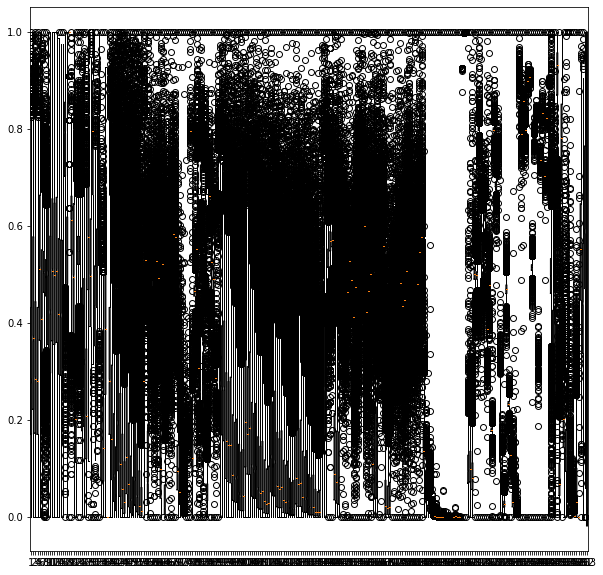

In [17]:
from sklearn.preprocessing import MinMaxScaler
# Standardization/Normalization
# As the data is positively distributed we use normalization

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_val_scale=scaler.transform(X_val)
X_test_scale=scaler.transform(X_test)

plt.figure(figsize=(10,10))
plt.boxplot(X_train_scale,notch=True);


#### Section 5: Classification

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(15,15))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Feature Selection using PCA

In [19]:
from sklearn.decomposition import PCA

pca = PCA(random_state=1)
X_train_pca = pca.fit_transform(X_train_scale)
exp_var = pca.explained_variance_ratio_
i = 0
j = 0
while i < 0.99:
    i+= exp_var[j]
    j+=1
PCAComp = j-1
print('PCA uses ', PCAComp, 'Features')
X_train_pca = X_train_pca[:,:PCAComp]
X_val_pca = pca.transform(X_val_scale)
X_val_pca = X_val_pca[:, :PCAComp]
X_test_pca = pca.transform(X_test_scale)
X_test_pca = X_test_pca[:, :PCAComp]

PCA uses  38 Features


Best Validation Score: 0.6552742086445741
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 15}
Random Forest test score : 0.6446608946608947
The validation score is 0.6446608946608947
Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

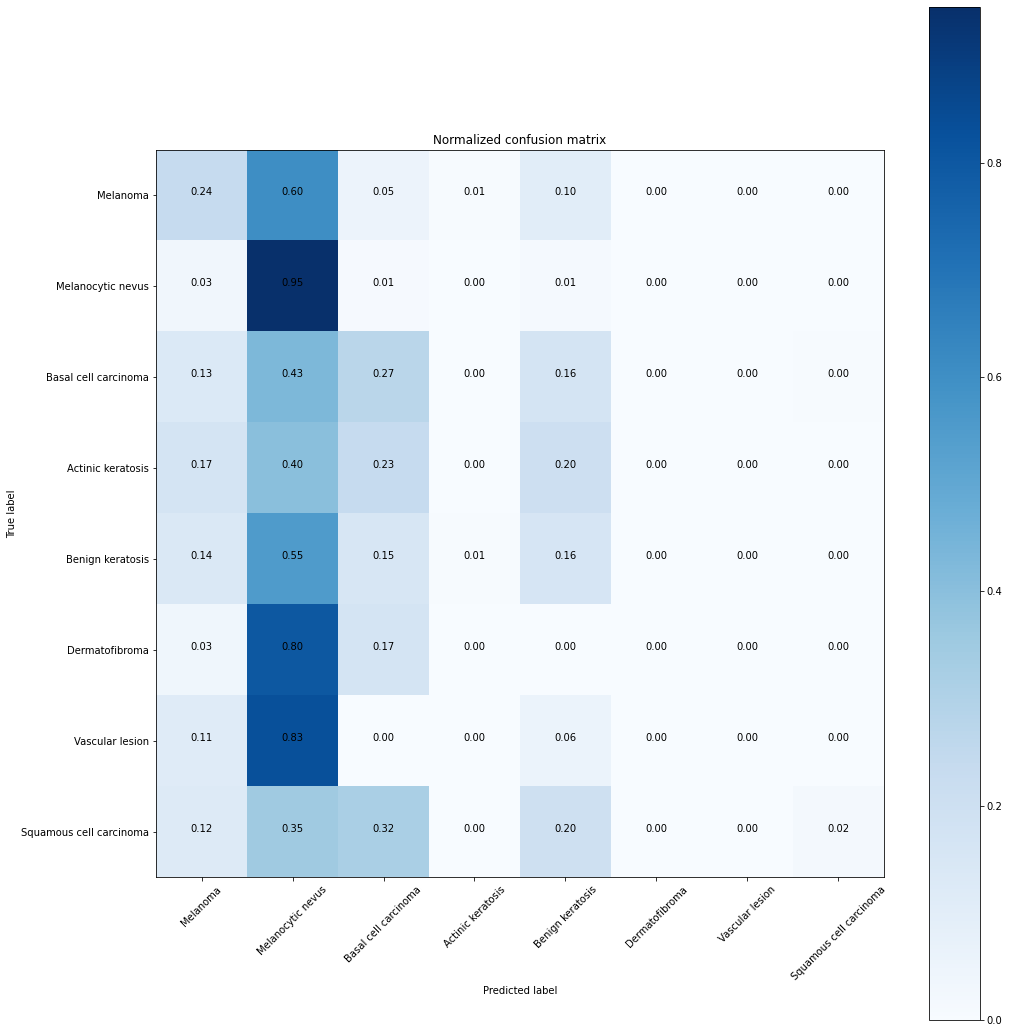

In [21]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train_pca, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_val_pca,y_val))

BestModel=grid_RF.best_estimator_
print('The validation score is', BestModel.score(X_val_pca, y_val))
y_pred = BestModel.predict(X_val_pca)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Fitting Non-linear SVM to the training set
The best C is 10.0  with an average validation score equal to  0.6783180387558259
The best gamma is 0.1  with an average validation score equal to  0.6783180387558259
The test score is 0.6771284271284271
Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

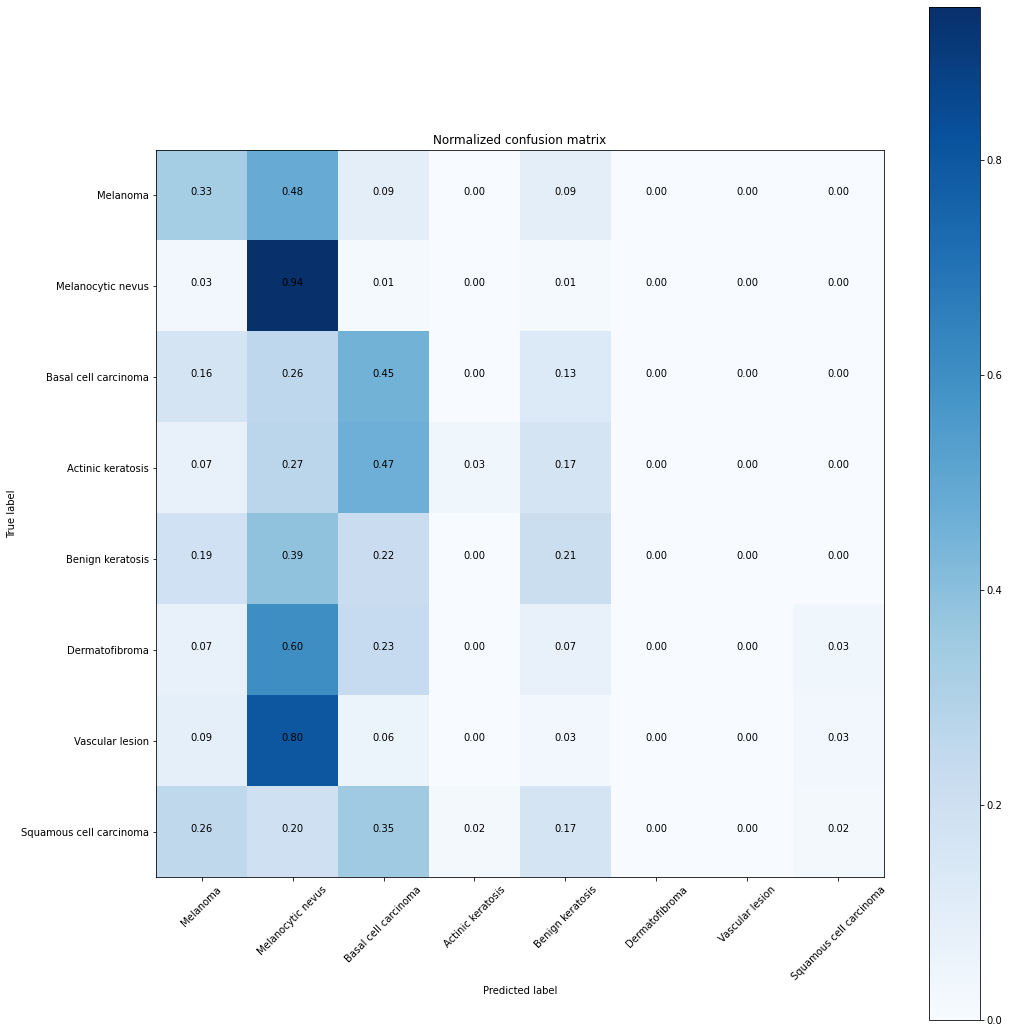

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# Looking for the best hyperparameter C 
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
p_grid_nlsvm = {'C': [1e-1,1,2,5,1e1],
              'gamma': [0.0001, 0.001, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_Nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring='accuracy', cv=5)
grid_Nlsvm.fit(X_train_pca, np.ravel(y_train))

print('The best C is', grid_Nlsvm.best_params_.get('C'), ' with an average validation score equal to ', grid_Nlsvm.best_score_)
print('The best gamma is', grid_Nlsvm.best_params_.get('gamma'), ' with an average validation score equal to ', grid_Nlsvm.best_score_)

# Look for the best estimator (the one with the greatest test accuracy)
BestModel=grid_Nlsvm.best_estimator_
print('The test score is', BestModel.score(X_val_pca, y_val))
y_pred = BestModel.predict(X_val_pca)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Make prediction on the data for Submission and Save the results to csv file

In [40]:
BestModel=grid_Nlsvm.best_estimator_
y_pred = BestModel.predict(X_test_pca)
y = pd.DataFrame(y_pred.astype(int), columns=['CLASS'])
submission = pd.concat([test_ids, y], axis=1)
diff =  list(set(test_dataset['ID']) - set(submission['ID']))
l = len(submission)
merged = submission.copy()
for i in range(len(diff)):
    dict={'ID':diff[i], 'CLASS':2}
    df = pd.DataFrame(dict, index=[l+i-1])
    merged = pd.concat([merged, df])

merged.to_csv('Submission.csv', index=False)